In [9]:
# Import libs
import sys
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.relax_linear import LinearRelaxer
import matplotlib.patches as mpatches
import numpy as np

from datos import *

try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

def imprimir_solucion(model):
    solution = model.solve()
    model.print_information()

    ancho = 100
    if solution:
        print(f"\n{'='*ancho}")
        print(f"{'RESULTADO'.center(ancho, ' ')}")
        print(f"{'='*ancho}")
        print(f"BENEFICIO: ${model.objective_value:.2f}")
        print(f"{'='*ancho}\n")

        # Imprimir variables
        print(f"\n{'Variables'.center(ancho, '-')}")
        print(f"{'Nombre'.ljust(40)}{'Valor'.rjust(30)}{'Reduced Cost'.rjust(30)}")
        print(f"{'-'*ancho}")
        for var in model.iter_variables():
            print(f"{var.name.ljust(40)}{str(round(var.solution_value, 2)).rjust(30)}{str(round(var.reduced_cost, 2)).rjust(30)}")
        
        # Imprimir restricciones
        print(f"{'Restricciones'.center(ancho, '-')}")
        print(f"{'Nombre'.ljust(40)}{'Slack'.rjust(30)}{'Dual Price'.rjust(30)}")
        print(f"{'-'*ancho}")
        for constraint in model.iter_constraints():
            print(f"{constraint.name.ljust(40)}{str(round(constraint.slack_value, 2)).rjust(30)}{str(round(constraint.dual_value, 2)).rjust(30)}")

        print(f"{'='*ancho}")
    else:
        print(f"{'='*ancho}")
        print("No se encontró una solución factible.")
        print(f"{'='*ancho}")

def imprimir_graficos(model, servicios, producido , costos, limites):
    # Datos necesarios
    produccion_graf = {servicio: producido[servicio].solution_value for servicio in servicios}
    total = sum(produccion_graf.values())

    fig, ax = plt.subplots()
    bars = ax.bar(produccion_graf.keys(), produccion_graf.values(), color='blue')
    # ax.axhline(y=total, color='r', linestyle='--', label='Total de producción')

    colores = {
        A: '#6b227d',
        B: '#ff6347',
        C: '#008000'
    }

    for servicio in servicios:
        ax.axhline(y=limites[servicio], color=colores[servicio], linestyle='--', label=f"Demanda max. {servicio}")
    ax.set_ylabel('Producción')
    ax.set_title('Producción con Límite Total')
    ax.legend()

    # Mostrar el valor sobre cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    costos = {
        "Produccion" : costos["materia_prima"].solution_value,
        "Translado" : costos["translado"].solution_value,
        "Horas Extra" : costos["horas_extra"].solution_value,
        "Capacidad Ociosa": costos["capacidad_ociosa"].solution_value
    }
    total = sum(costos.values())
    porcentaje_costos = {tipo: (valor / total) * 100 for tipo, valor in costos.items() if valor > 0}

    # Gráfico de pastel para representar el porcentaje de cada aceite en el producto final
    plt.figure(figsize=(8, 8))
    plt.pie(porcentaje_costos.values(), labels=porcentaje_costos.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'lightpink'])
    plt.title('Porcentaje de cada costo respecto del costo total')
    plt.show()

def perform_sensitivity_analysis(model):
    lp = LinearRelaxer.make_relaxed_model(model)
    lp.solve()
    cpx = lp.get_engine().get_cplex()
    return cpx.solution.sensitivity.rhs(), cpx.solution.sensitivity.objective()

def analisis_sensibilidad(model):
    ancho = 120
    print(f"\n{'='*ancho}")
    print(f"{'Análisis de sensibilidad'.center(ancho, ' ')}")
    print(f"{'='*ancho}")
    sensitivity_rhs, sensitivity_objective = perform_sensitivity_analysis(model)

    print(f"{'Variables'.center(ancho, '-')}")
    print(f"{'Variable'.ljust(50)}{'Coeficiente'.ljust(10)}{'Lim inferior'.rjust(30)}{'Lim superior'.rjust(30)}")
    print(f"{'-'*ancho}")

    for idx, var in enumerate(model.iter_variables()):
        coeficiente_actual = model.objective_coef(var)
        rango_inferior, rango_superior = sensitivity_objective[idx]
        if rango_inferior == -1e+20:
            rango_inferior = "Infinity"
        else:
            rango_inferior = str(round(rango_inferior, 2))
        if rango_superior == 1e+20:
            rango_superior = "Infinity"
        else:
            rango_superior = str(round(rango_superior, 2))
        
        print(f"{var.name.ljust(50)}{str(round(coeficiente_actual, 2)).ljust(10)}{rango_inferior.rjust(30)}{rango_superior.rjust(30)}")
    print(f"{'='*ancho}")

    print(f"{'Restricciones'.center(ancho, '-')}")
    print(f"{'Nombre'.ljust(40)}{'Lim inferior'.rjust(30)}{'Lim superior'.rjust(30)}")
    print(f"{'-'*ancho}")   
    for idx, c in enumerate(model.iter_constraints()):
        if idx < len(sensitivity_rhs):
            lim_inf, lim_sup = sensitivity_rhs[idx]
            if lim_inf == -1e+20:
                lim_inf = "Infinity"
            else:
                lim_inf = str(round(lim_inf, 2))
            if lim_sup == 1e+20:
                lim_sup = "Infinity"
            else:
                lim_sup = str(round(lim_sup, 2))
            print(f"{c.name.ljust(40)}{lim_inf.rjust(30)}{lim_sup.rjust(30)}")
    print(f"{'='*ancho}")

# PROBLEMA ORIGINAL - Papelera Godoy

### POSIBLES HIPOTESIS
1. si me llegan a entrar 7000 cajas, las cuales supera el limite de produccion, entonces no se produce nada, porque no cumple la restriccion -> eso significa que la empresa no trabaja / no toma el pedido ya que no tiene capacidad para producirlo

### Horas Extras:
Como para la produccion de B no tenemos restricciones, a cierto valor de demanda de B, se van a requerir horas extras 

Model: TP: Equipo A SRL (CASO BASE)
 - number of variables: 10
   - binary=0, integer=0, continuous=10
 - number of constraints: 11
   - linear=11
 - parameters: defaults
 - objective: maximize
 - problem type is: LP

                                             RESULTADO                                              
BENEFICIO: $1117059.52


---------------------------------------------Variables----------------------------------------------
Nombre                                                           Valor                  Reduced Cost
----------------------------------------------------------------------------------------------------
Producido_Ensobrado                                           240000.0                             0
Cantidad_Cajas_A_Comprar_Para_Ensobrado                          800.0                             0
Consumo_horas_produccion_de_Ensobrado                            400.0                             0
Producido_Etiquetado                              

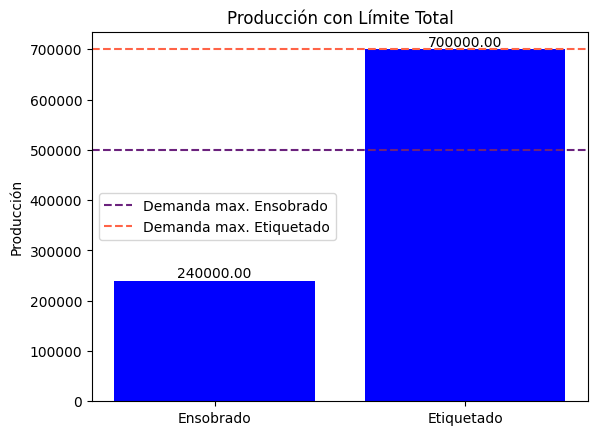

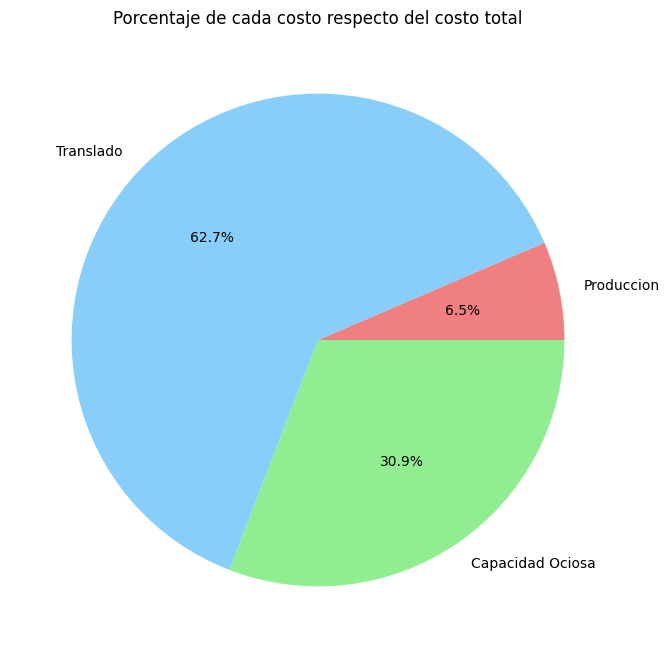

In [10]:
mdl = Model(name="TP: Equipo A SRL (CASO BASE)")

producido = dict()
cantidad_cajas = dict()
horas_produccion_producto = dict()

for servicio in servicios:
    producido[servicio] = mdl.continuous_var(name=f'Producido_{servicio}')
    cantidad_cajas[servicio] = mdl.continuous_var(name=f"Cantidad_Cajas_A_Comprar_Para_{servicio}")
    horas_produccion_producto[servicio] = mdl.continuous_var(name=f"Consumo_horas_produccion_de_{servicio}")
horas_maquina = mdl.continuous_var(name=f"Consumo_horas_maquina")
horas_extra = mdl.continuous_var(name=f"Horas_Extra")
capacidad_ociosa = mdl.continuous_var(name=f"Horas_Sobrantes")
cantidad_translados = mdl.continuous_var(name=f"Cantidad_Translados")

#-- RESTRICCIONES --
#-- DEMANDA MAXIMA --
for servicio in servicios:
    mdl.add_constraint(producido[servicio] <= LIMITES_PRODUCCION[servicio],f"Limite_de_produccion_{servicio}")

#-- CONSUMO RECURSOS --
# Consumo de cajas
for servicio in servicios:
    mdl.add_constraint(CAPACIDAD_CAJA[servicio]*cantidad_cajas[servicio] == producido[servicio],f"Capacidad_caja_{servicio}")


# Consumo de maquina
mdl.add_constraint(PRODUCCION_MAQUINA[M1]*horas_maquina == producido[A],f"Produccion_Maquina") # Solo el producto A tiene un proceso de maquina
mdl.add_constraint(horas_maquina <= LIMITE_HORAS_MAQUINA[M1],f"Limite_horas_maquina")

# Consumo horas trabajo
for servicio in servicios:
    mdl.add_constraint(PRODUCCION_HORA[servicio]*horas_produccion_producto[servicio] == producido[servicio],f"Produccion_hora_{servicio}")
horas_produccion = horas_produccion_producto[A] + horas_produccion_producto[B]
    
# Traslado
mdl.add_constraint(CAPACIDAD_TRANSLADO[A]*cantidad_translados == producido[A],f"Capacidad_traslado")

#-- Restricciones horarias --
mdl.add_constraint(PERSONAL_NECESARIO_MAQUINA[M1]*horas_maquina + horas_produccion == LIMITE_HORAS_HOMBRE + horas_extra - capacidad_ociosa,f"Restriccion_horaria")


#-- Max Horas extra --
mdl.add_constraint(horas_extra <= MAX_HORAS_EXTRA_PERSONAL, f"Maximo_horas_extra")

ingresos = mdl.sum(PRECIO_VENTA[servicio]*producido[servicio] for servicio in servicios)
costos_materia_prima = mdl.sum(PRECIO_CAJAS*cantidad_cajas[servicio] for servicio in servicios)
costo_horas_extra = horas_extra*PRECIO_HORA_EXTRA
costo_capacidad_ociosa = capacidad_ociosa*PRECIO_CAPACIDAD_OCIOSA
costo_translado = cantidad_translados*PRECIO_TRANSLADO[A]

costos = costos_materia_prima + costo_horas_extra + costo_capacidad_ociosa + costo_translado

beneficio = ingresos - costos
mdl.maximize(beneficio)

# Imprimir la soluciÃ³n
imprimir_solucion(mdl)
costos_totales = {
    "materia_prima": costos_materia_prima,
    "horas_extra": costo_horas_extra,
    "capacidad_ociosa": costo_capacidad_ociosa,
    "translado": costo_translado
}
analisis_sensibilidad(mdl)
imprimir_graficos(mdl, servicios, producido, costos_totales, LIMITES_PRODUCCION)

# PROBLEMA 2 (Agregar nuevo producto)

Model: TP: Equipo A SRL (NUEVO PRODUCTO)
 - number of variables: 16
   - binary=0, integer=0, continuous=16
 - number of constraints: 17
   - linear=17
 - parameters: defaults
 - objective: maximize
 - problem type is: LP

                                             RESULTADO                                              
BENEFICIO: $1483299.52


---------------------------------------------Variables----------------------------------------------
Nombre                                                           Valor                  Reduced Cost
----------------------------------------------------------------------------------------------------
Cantidad_tinta_a_comprar_para_diarios                          96000.0                             0
Producido_Ensobrado                                           240000.0                             0
Consumo_horas_produccion_de_Ensobrado                            400.0                             0
Cantidad_Cajas_A_Comprar_Para_Ensobrado      

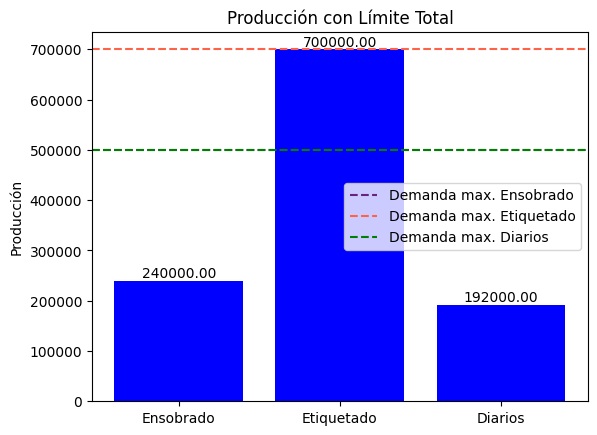

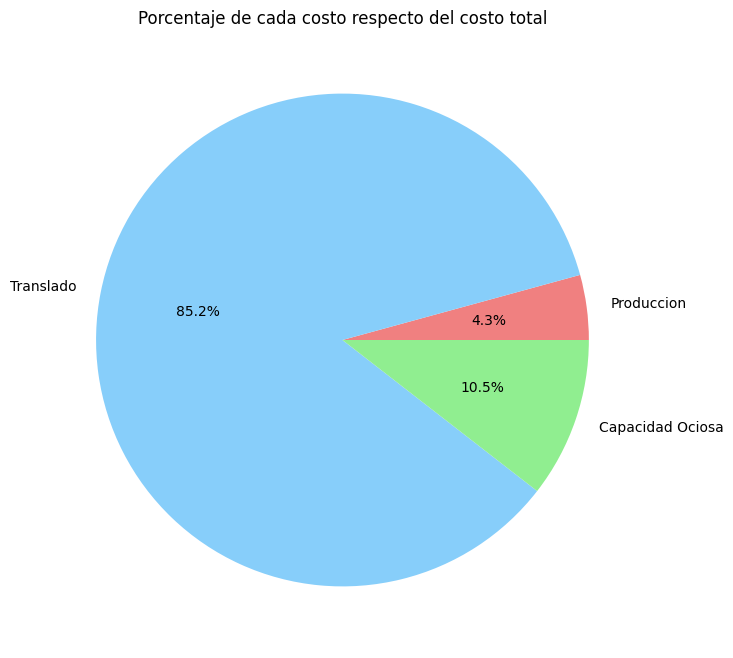

In [11]:
# Servicios
servicios.append(C)
maquinas.append(M2)

# #-------- MODELO 2 --------

mdl = Model(name="TP: Equipo A SRL (NUEVO PRODUCTO)")

cantidad_tinta = mdl.continuous_var(name=f"Cantidad_tinta_a_comprar_para_diarios")
cantidad_cajas = dict()
producido = dict()
horas_produccion_producto = dict()
horas_maquina = dict()

for servicio in servicios:
    producido[servicio] = mdl.continuous_var(name=f'Producido_{servicio}')
    horas_produccion_producto[servicio] = mdl.continuous_var(name=f"Consumo_horas_produccion_de_{servicio}")
    if servicio != C:
        cantidad_cajas[servicio] = mdl.continuous_var(name=f"Cantidad_Cajas_A_Comprar_Para_{servicio}")

for maquina in maquinas:
    horas_maquina[maquina] = mdl.continuous_var(name=f"Consumo_horas_maquina__{maquina}")

horas_produccion = mdl.continuous_var(name=f"Consumo_horas_produccion")
horas_extra = mdl.continuous_var(name=f"Horas_Extra")
capacidad_ociosa = mdl.continuous_var(name=f"Horas_Sobrantes")
cantidad_translados_sobres = mdl.continuous_var(name=f"Cantidad_Translados_sobres")
cantidad_translados_diarios = mdl.continuous_var(name=f"Cantidad_Translados_diarios")

# #-- RESTRICCIONES --
# #-- DEMANDA MAXIMA --
for servicio in servicios:
    mdl.add_constraint(producido[servicio] <= LIMITES_PRODUCCION[servicio], f"Demanda_Maxima_{servicio}")

# #-- CONSUMO RECURSOS --
# # Consumo de cajas y tinta
for servicio in servicios:
    if servicio == C:
        mdl.add_constraint(cantidad_tinta == producido[servicio] * TINTA_DIARIO,f"Consumo_de_{servicio}")
    else: 
        mdl.add_constraint(CAPACIDAD_CAJA[servicio]*cantidad_cajas[servicio] == producido[servicio],f"Consumo_de_{servicio}")

# # Consumo de maquina
mdl.add_constraint(PRODUCCION_MAQUINA[M1]*horas_maquina[M1] == producido[A],f"Consumo_Maquina_1") 
mdl.add_constraint(PRODUCCION_MAQUINA[M2]*horas_maquina[M2] == producido[C], f"Consumo_Maquina_2")

for maquina in maquinas:
    mdl.add_constraint(horas_maquina[maquina] <= LIMITE_HORAS_MAQUINA[maquina], f"Limite_horas_{maquina}")

# Consumo horas trabajo
for servicio in servicios:
    mdl.add_constraint(PRODUCCION_HORA[servicio]*horas_produccion_producto[servicio] == producido[servicio],f"Consumo_horas_{servicio}")
horas_produccion = mdl.sum(horas_produccion_producto[servicio] for servicio in servicios)

# Translado
mdl.add_constraint(CAPACIDAD_TRANSLADO[A]*cantidad_translados_sobres == producido[A],f"Cantidad_traslados_sobres")
mdl.add_constraint(CAPACIDAD_TRANSLADO[C]*cantidad_translados_diarios == producido[C],f"Cantidad_traslados_diario")


#-- Restricciones horarias --
suma_horas_maquina = (PERSONAL_NECESARIO_MAQUINA[M1]*horas_maquina[M1]) + (PERSONAL_NECESARIO_MAQUINA[M2]*horas_maquina[M2])
mdl.add_constraint(suma_horas_maquina + horas_produccion == LIMITE_HORAS_HOMBRE + horas_extra - capacidad_ociosa,f"Restriccion_horaria")


#-- Max Horas extra --
mdl.add_constraint(horas_extra <= MAX_HORAS_EXTRA_PERSONAL,f"Maximo_horas_extra")

# #-- FUNCIONAL -- 
# # Ingresos
ingresos = mdl.sum(PRECIO_VENTA[servicio]*producido[servicio] for servicio in servicios)

# Costos
costo_materia_prima_sobres = mdl.sum(PRECIO_CAJAS*cantidad_cajas[servicio] for servicio in servicios if servicio != C) 
costo_materia_prima_diarios = PRECIO_TINTA * cantidad_tinta / 1000 
costos_materia_prima = costo_materia_prima_sobres + costo_materia_prima_diarios

costo_horas_extra = horas_extra*PRECIO_HORA_EXTRA
costo_capacidad_ociosa = capacidad_ociosa*PRECIO_CAPACIDAD_OCIOSA

costo_translado = cantidad_translados_sobres*PRECIO_TRANSLADO[A] + cantidad_translados_diarios*PRECIO_TRANSLADO[C]

costos = costos_materia_prima + costo_horas_extra + costo_capacidad_ociosa + costo_translado

beneficio = ingresos - costos
mdl.maximize(beneficio)

# Imprimir la soluciÃ³n
imprimir_solucion(mdl)
costos_totales = {
    "materia_prima": costos_materia_prima,
    "horas_extra": costo_horas_extra,
    "capacidad_ociosa": costo_capacidad_ociosa,
    "translado": costo_translado
}
analisis_sensibilidad(mdl)
imprimir_graficos(mdl, servicios, producido, costos_totales, LIMITES_PRODUCCION)

servicios.remove(C)
maquinas.remove(M2)

# PROBLEMA 3 (Control de calidad)

Model: TP: Equipo A SRL (CONTROL DE CALIDAD)
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 13
   - linear=13
 - parameters: defaults
 - objective: maximize
 - problem type is: LP

                                             RESULTADO                                              
BENEFICIO: $1189749.52


---------------------------------------------Variables----------------------------------------------
Nombre                                                           Valor                  Reduced Cost
----------------------------------------------------------------------------------------------------
Producido_Ensobrado                                           240000.0                             0
Cantidad_Cajas_A_Comprar_Para_Ensobrado                          800.0                             0
Consumo_horas_produccion_de_Ensobrado                            400.0                             0
Producido_Etiquetado                     

-------------------------------------------------------Variables--------------------------------------------------------
Variable                                          Coeficiente                  Lim inferior                  Lim superior
------------------------------------------------------------------------------------------------------------------------
Producido_Ensobrado                               3.2                                 1.41                      Infinity
Cantidad_Cajas_A_Comprar_Para_Ensobrado           -15                              -551.23                      Infinity
Consumo_horas_produccion_de_Ensobrado             0                               -1072.46                      Infinity
Producido_Etiquetado                              1.28                               -0.34                      Infinity
Cantidad_Cajas_A_Comprar_Para_Etiquetado          -15                              -744.75                      Infinity
Consumo_horas_produccion_de_Eti

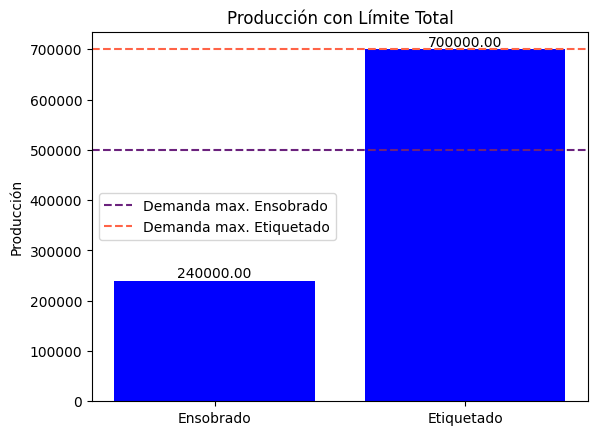

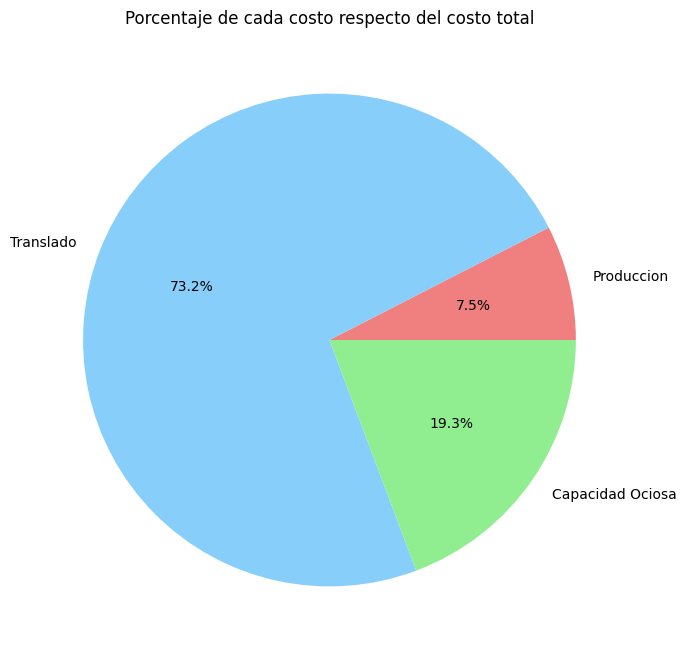

In [12]:
# Reparacion
PORCENTAJE_RECHAZO_MAQUINA = {
    M1: 0.02 #0.02
}
COSTO_REPARACION_SOBRES = 1.2 # 1.2



# --- Modelo 3

mdl = Model(name="TP: Equipo A SRL (CONTROL DE CALIDAD)")

producido = dict()
cantidad_cajas = dict()
horas_produccion_producto = dict()
for servicio in servicios:
    producido[servicio] = mdl.continuous_var(name=f'Producido_{servicio}')
    cantidad_cajas[servicio] = mdl.continuous_var(name=f"Cantidad_Cajas_A_Comprar_Para_{servicio}")
    horas_produccion_producto[servicio] = mdl.continuous_var(name=f"Consumo_horas_produccion_de_{servicio}")

horas_maquina = mdl.continuous_var(name=f"Consumo_horas_maquina")
horas_extra = mdl.continuous_var(name=f"Horas_Extra")
horas_reparacion_sobres = mdl.continuous_var(name=f"consumo_horas_reparacion_sobres")
capacidad_ociosa = mdl.continuous_var(name=f"Horas_Sobrantes")
cantidad_translados = mdl.continuous_var(name=f"Cantidad_Translados")
rechazados_por_maquina = mdl.continuous_var(name=f"cantidad_rechazados_maquina_1")

#-- RESTRICCIONES --
#-- DEMANDA MAXIMA --
for servicio in servicios:
    mdl.add_constraint(producido[servicio] <= LIMITES_PRODUCCION[servicio], f"Demanda_maxima_{servicio}")

#-- CONSUMO RECURSOS --
# Consumo de cajas
for servicio in servicios:
    mdl.add_constraint(CAPACIDAD_CAJA[servicio]*cantidad_cajas[servicio] == producido[servicio],f"Consumo_cajas_{servicio}")

# Consumo de maquina
mdl.add_constraint(PRODUCCION_MAQUINA[M1]*horas_maquina == producido[A], f"Consumo_maquina_1") # Solo el producto A tiene un proceso de maquina
mdl.add_constraint(horas_maquina <= LIMITE_HORAS_MAQUINA[M1],f"Limite_horas_maquina")
mdl.add_constraint(rechazados_por_maquina == producido[A] * PORCENTAJE_RECHAZO_MAQUINA[M1],f"Rechazados_maquina_1")

# Consumo horas trabajo
for servicio in servicios:
    mdl.add_constraint(PRODUCCION_HORA[servicio]*horas_produccion_producto[servicio] == producido[servicio],f"Consumo_horas_trabajo")
horas_produccion = mdl.sum(horas_produccion_producto[servicio] for servio in servicios)

# Translado
mdl.add_constraint(CAPACIDAD_TRANSLADO[A]*cantidad_translados == producido[A],f"Cantidad_traslado_{A}")

#-- Restricciones horarias --
mdl.add_constraint(PERSONAL_NECESARIO_MAQUINA[M1]*horas_maquina + horas_produccion + horas_reparacion_sobres == LIMITE_HORAS_HOMBRE + horas_extra - capacidad_ociosa,f"Restriccion_horaria")

#-- Rechazo maquinas --
mdl.add_constraint(rechazados_por_maquina == horas_reparacion_sobres * REPARACION_HORA[A],f"Rechazo_maquinas")

#-- Max Horas extra --
mdl.add_constraint(horas_extra <= MAX_HORAS_EXTRA_PERSONAL,f"Maximo_horas_extra")


ingresos = mdl.sum(PRECIO_VENTA[servicio]*producido[servicio] for servicio in servicios)

costos_materia_prima = mdl.sum(PRECIO_CAJAS*cantidad_cajas[servicio] for servicio in servicios)
costo_horas_extra = horas_extra*PRECIO_HORA_EXTRA
costo_capacidad_ociosa = capacidad_ociosa*PRECIO_CAPACIDAD_OCIOSA
costo_translado = cantidad_translados*PRECIO_TRANSLADO[A]
costo_reparado = rechazados_por_maquina * COSTO_REPARACION_SOBRES

costos = costos_materia_prima + costo_horas_extra + costo_capacidad_ociosa + costo_translado + costo_reparado

beneficio = ingresos - costos
mdl.maximize(beneficio)


# Imprimir la soluciÃ³n
imprimir_solucion(mdl)
costos_totales = {
    "materia_prima": costos_materia_prima,
    "horas_extra": costo_horas_extra,
    "capacidad_ociosa": costo_capacidad_ociosa,
    "translado": costo_translado
}
analisis_sensibilidad(mdl)
imprimir_graficos(mdl, servicios, producido, costos_totales, LIMITES_PRODUCCION)